# Sea Ice Extent Timeseries
## **SODA**

In [73]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [75]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.0d7071da8cd742db9bc93c13fd3343c3 Dashboard: /services/dask-gateway/clusters/staging.0d7071da8cd742db9bc93c13fd3343c3/status,Cluster Workers: 2 Cores: 4 Memory: 16.00 GiB


In [ ]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [5]:
path = "s3://Pangeo/pangeo-forge/soda342/5day_ice.zarr"
mapper = fsspec.get_mapper(
    path, anon=True, client_kwargs={'endpoint_url': 'https://ncsa.osn.xsede.org'},
)
ds = xr.open_zarr(mapper, consolidated=True)
print(ds)

<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 2117, xb: 1441, xt: 1440, xv: 1440, yb: 1071, yt: 1070, yv: 1070)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * time         (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yb           (yb) float64 -80.07 -79.97 -79.86 -79.76 ... 78.84 78.85 78.85
  * yt           (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.84 78.84 78.85
  * yv           (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85
Data variables:
    average_DT   (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) datetime64[ns] dask

In [6]:
ds

<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 2117, xb: 1441, xt: 1440, xv: 1440, yb: 1071, yt: 1070, yv: 1070)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * time         (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yb           (yb) float64 -80.07 -79.97 -79.86 -79.76 ... 78.84 78.85 78.85
  * yt           (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.84 78.84 78.85
  * yv           (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85
Data variables:
    average_DT   (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    cn           (time, ct, yt, xt) float32 dask.array<chunksize=(1, 5, 1070, 1440), meta=np.ndarray>
    hi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hs           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ix_trans     (time, yt, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    iy_trans     (time, yv, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ui           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    vi           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ice_or_1992_01_05.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [10]:
ds.cn

,Array,Chunk
Bytes,60.76 GiB,29.39 MiB
Shape,"(2117, 5, 1070, 1440)","(1, 5, 1070, 1440)"
Count,2118 Tasks,2117 Chunks
Type,float32,numpy.ndarray


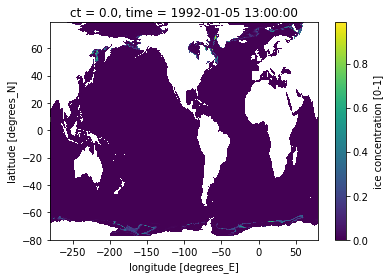

In [13]:
ds.cn[0,0].plot();

In [14]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [43]:
#set the boundaries
lat_range = dict(yt=slice(lower_lat, upper_lat), yv=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt=slice(left_lon, right_lon), xv=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt=slice(left_lon, right_lon))

#lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
#lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [44]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [20]:
ice = ds.cn.isel(**lat_range_no_u, **lon_range_no_u)
#ds_wg = ds.isel(**lat_range, **lon_range)

In [21]:
ice

,Array,Chunk
Bytes,2.54 GiB,1.23 MiB
Shape,"(2117, 5, 169, 381)","(1, 5, 169, 381)"
Count,4235 Tasks,2117 Chunks
Type,float32,numpy.ndarray


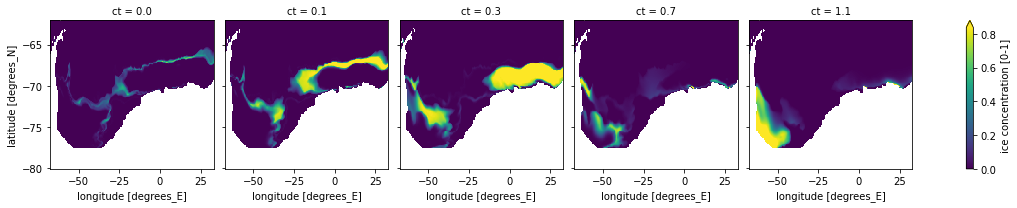

In [30]:
ice.isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

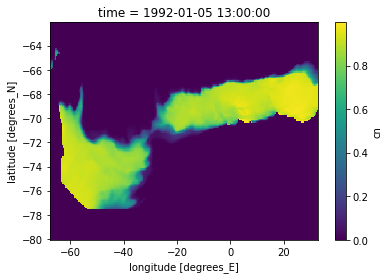

In [58]:
ice.sum('ct')[0].plot();

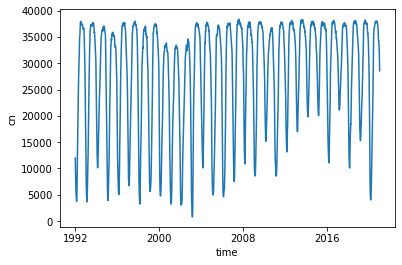

In [76]:
ice.sum(['ct', 'yt', 'xt']).plot();

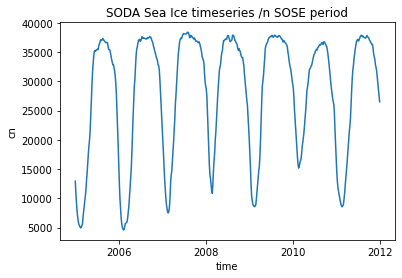

In [80]:
ice.sum(['ct', 'yt', 'xt']).sel(time=slice('2005', '2011')).plot()
plt.title('SODA Sea Ice timeseries /n SOSE period');